In [1]:
import re
import os
from pathlib import Path
import pickle
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from scipy.optimize import curve_fit
from lmfit import Model
from lmfit.models import LinearModel

sys.path.append(os.path.join(Path(os.getcwd()).parents[0], "functions"))
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hfn
import math

In [2]:
def func(x, a, b, c):
	return a * x**2 + b * x + c

In [3]:
model_lm = LinearModel()

In [4]:
path = Path(os.getcwd()).parents[0]

alldatapath = os.path.join(path, 'data')
datapath = os.path.join(alldatapath, 'clean')

likpath = os.path.join(path, 'data/likelihood_fit_bnds_from_allen_2022')

fracpath = os.path.join(path, 'input_fraction')
fracpath_csv = os.path.join(fracpath, 'csv')

figpath = os.path.join(path, 'figures')
hfn.dir_check(figpath)

figs61path = os.path.join(figpath, 'FigS19')
hfn.dir_check(figs61path)

figs61panelpaths = os.path.join(figs61path, 'panels')
hfn.dir_check(figs61panelpaths)

# Load data

In [5]:
data  = pd.read_hdf(os.path.join(datapath, 'df_filt_ipsi.h5'))

In [6]:
datafrac = pd.read_csv(os.path.join(fracpath_csv, 'df_all_fraction.csv'))

In [7]:
areas = ['VISp','VISpm','VISl', 'VISam', 'VISal', 'RSPagl', 'RSPd', 'RSPv', 'AM', 'LD', 'LP', 'LGd', 'ORB', 'ACA', 'MOs', 'CLA', 'PTLp', 'TEa', 'AUD',]

In [8]:
data['rest'] = data['input'] - sum(data[area] for area in areas)

In [9]:
areas.append('rest')

# Load model data

In [10]:
summary_df_all = pd.DataFrame()
summary_df_ratio_all = pd.DataFrame()
params_dict = []

for file in os.listdir(likpath):
    if file.startswith('summary_df_ns'):
        
        index = re.findall('\d+',file)[0]
#         print(index)
        summary_df = pd.read_hdf(os.path.join(likpath, 'summary_df_ns_'+index+'.h5'))
        summary_df['file'] = index
        summary_df['input'] = sum(summary_df['inputs'+str(i)] for i in range(20))
        summary_df_all = pd.concat([summary_df_all, summary_df], axis = 0)#.reset_index(drop = True)
        
        summary_df_ratio = summary_df.iloc[:,1:21].copy()
        
        summary_df_ratio = summary_df_ratio.divide(summary_df['input'].values, axis = 0)
        summary_df_ratio['file'] = index
        summary_df_ratio['starters'] = summary_df['starters'] 
        
        summary_df_ratio_all = pd.concat([summary_df_ratio_all, summary_df_ratio], axis = 0)
        with open(os.path.join(likpath,'de_model_same_pbnds_'+index+'.pkl'), 'rb') as fp:
            params = pickle.load(fp)
        for i in range(int(len(params)/2)):
            params_dict.append({'file': index, 'Ni' : int(params[2*i]), 'p' : params[2*i + 1]})
params_df_all = pd.DataFrame(params_dict)

In [11]:
keys = ['inputs'+str(i) for i in range(20)]
dict_col = {}
for ind, i in enumerate(keys):
    dict_col[i] = areas[ind]

In [12]:
summary_df_all = summary_df_all.rename(columns = dict_col)

In [13]:
# to plot for examples 
thissummary_df = summary_df_all[summary_df_all.file == '76']
thisparams_df = params_df_all[params_df_all.file == '76']

In [14]:
areas_main_fig = ['VISp', 'RSPv', 'LP', 'ORB']
areas_to_plot = [item for item in areas if item not in areas_main_fig ]

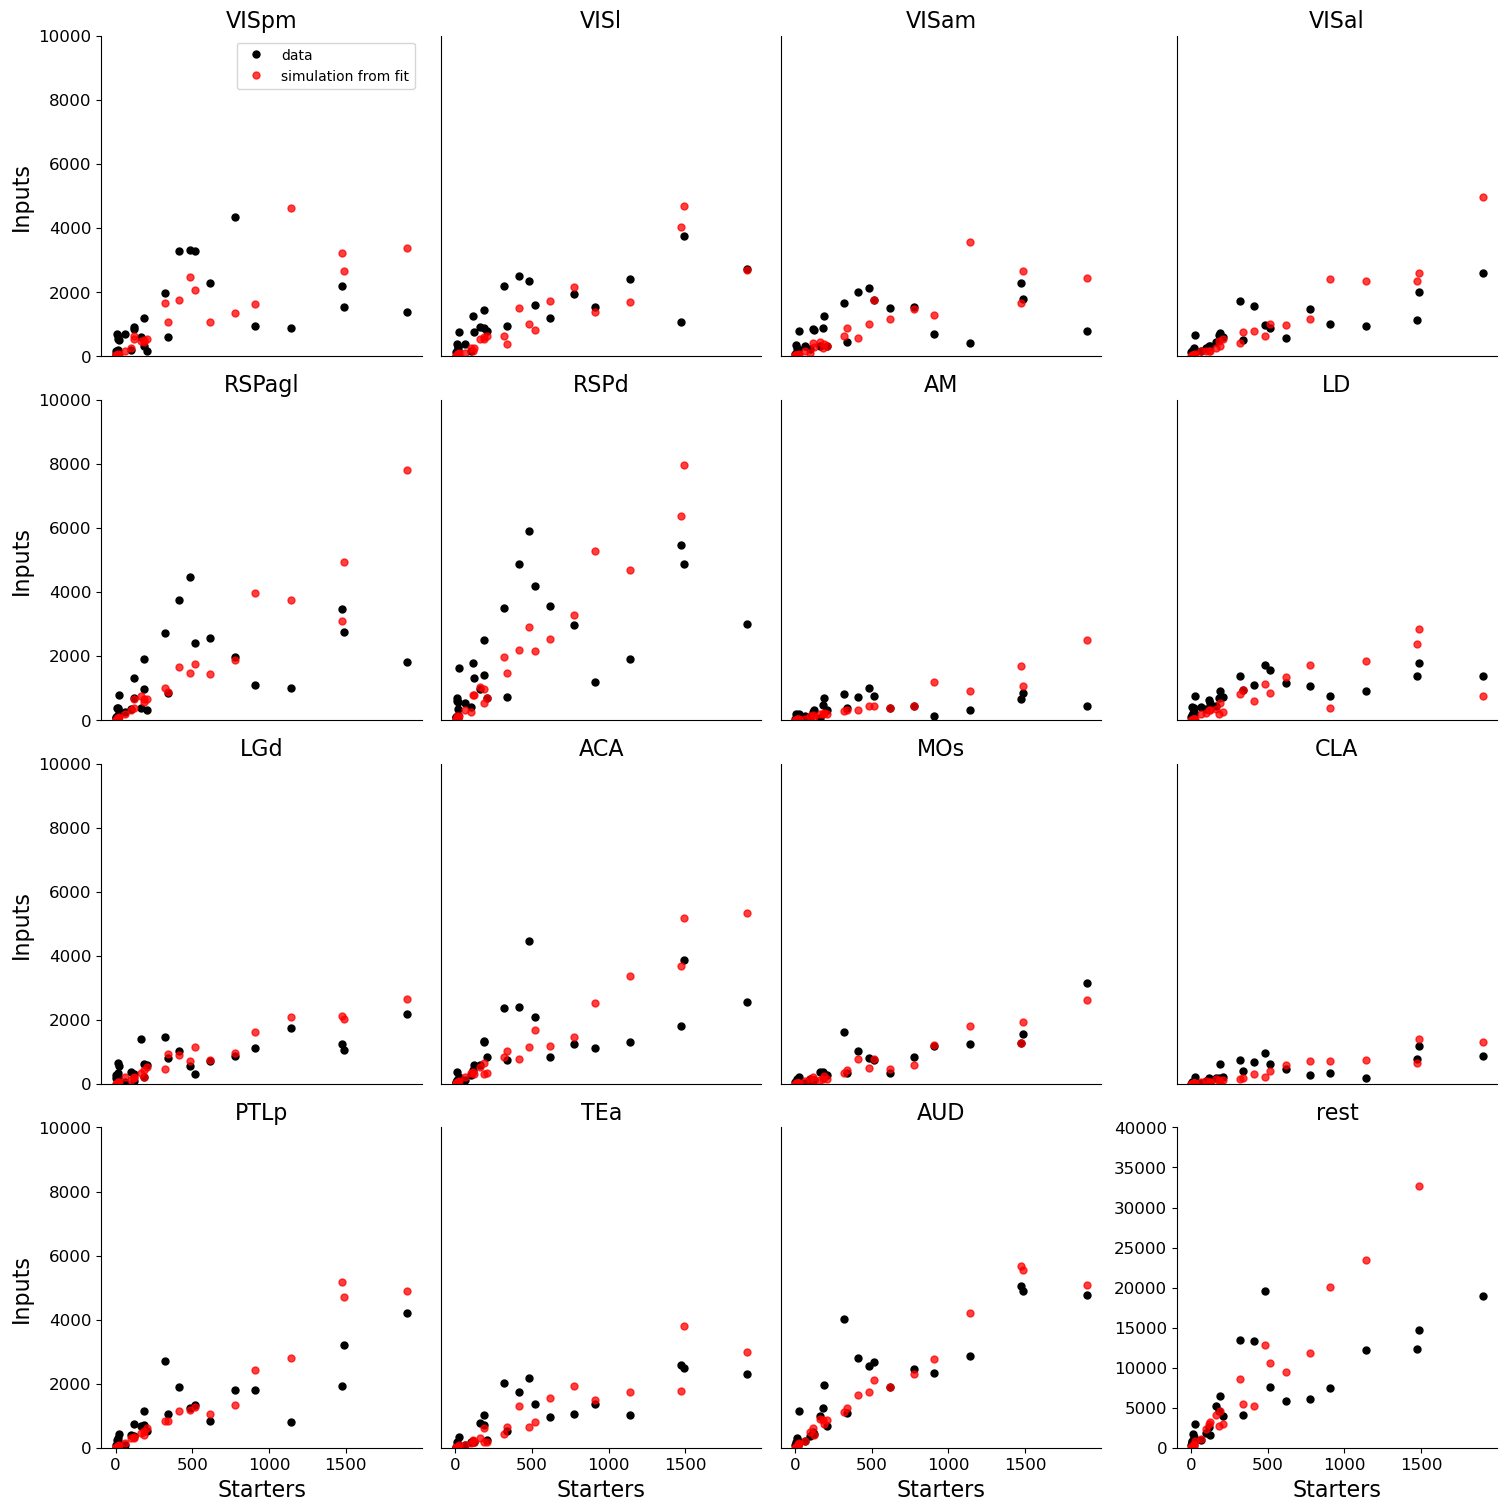

In [15]:
f1 = plt.figure(constrained_layout = True)

gs = f1.add_gridspec(4,8)

ax = {}

for i, area in enumerate(areas_to_plot):
    if i%4 ==0 :
        ax[i] = f1.add_subplot(gs[int(i/4):int(i/4)+1, 0:2])
        ax[i].set_ylabel('Inputs', fontsize = 16)
    elif i%4 == 1:
        ax[i] = f1.add_subplot(gs[int(i/4):int(i/4)+1, 2:4])

        if area not in [ 'VISpm']:
            ax[i].yaxis.set_visible(False)        
    elif i%4 == 2:
        ax[i] = f1.add_subplot(gs[int(i/4):int(i/4)+1, 4:6])
#         if area not in ['VISl']:
        ax[i].yaxis.set_visible(False)
    else:
        ax[i] = f1.add_subplot(gs[int(i/4):int(i/4)+1, 6:])
        if area not in ['rest']:
            ax[i].yaxis.set_visible(False)
    ax[i].plot(data.starter.values, data[area].values, 'o', label = 'data', c='k', ms = 5)
    ax[i].plot(thissummary_df.starters, thissummary_df[area], 'o', alpha = 0.75, label = 'simulation from fit', c='r', ms= 5)
    if i == 0:
        plt.legend()
    ax[i].set_title(area, fontsize = 16 )#+ r', $N_{i} = $' + str(thisparams_df['Ni'].iloc[i])+ r', $p = $' + str("{:.2e}".format(thisparams_df['p'].iloc[i])))
    
    if area == 'rest':
        ax[i].set_ylim(0, 40000)
    elif area == 'VISp':
        ax[i].set_ylim(0, 20000)
# 
    else:
        ax[i].set_ylim(0, 10000)
        
    if area == 'AUD' or area =='rest' or area == 'TEa' or area == 'PTLp':
        ax[i].set_xlabel('Starters', fontsize = 16)
    else:
        ax[i].xaxis.set_visible(False)
        
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_aspect(1.0/ax[i].get_data_ratio(), adjustable='box')

    ax[i].set_rasterized(True)
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(12)

f1.set_size_inches(15, 15)
plt.savefig(os.path.join(figs61panelpaths, 'figS19.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(figs61panelpaths, 'figS19.eps'), bbox_inches = 'tight', format = 'eps', dpi = 200)